# Dependencies and data import

In [ ]:
# !sudo apt-get install graphviz
# !pip install graphviz
# !pip install pydot
# !pip install xgboost
# !pip install hyperopt

## Libraries

In [24]:
# Data Analysis
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Pycaret
from pycaret.classification import *

# Machine Learning
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, GridSearchCV
from hyperopt import hp
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from IPython.display import SVG
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree, plot_importance
from sklearn.svm import LinearSVC, SVC


import joblib

# Notebook Settings
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_columns')
import warnings
warnings.filterwarnings('ignore')

## Functions

In [32]:
def metricas(y,y_hat):
    # función para pintar las métricas de modelo
    print('------------------------------------------------------')
    print('ACCURACY_SCORE')
    print( accuracy_score(y, y_hat) )
    print('------------------------------------------------------')
    print('REAL Y')
    print(y.iloc[:,0].value_counts())
    print('------------------------------------------------------')
    print('PRED Y')
    print(y_hat.iloc[:,0].value_counts())
    print('------------------------------------------------------')
#    print('')
    cnf_matrix_1=confusion_matrix(y, y_hat)
    res=pd.DataFrame(y)
    classes_names = res.iloc[:,0].unique()
    
    print(list_cm(cnf_matrix_1, classes=classes_names))
#    print('')
    print('------------------------------------------------------')
    print('Precision: True Possitives / all positive predictions. Low precision indicates a high number of false positives.')
    print('Recall: True positives / positive values in the test data. Low recall indicates a high number of false negatives.')
    print('F1: Score: the weighted average of precision and recall.')
    print('')
    print(classification_report(y, y_hat))
    print('------------------------------------------------------')
    
def plot_roc(y, y_hat):
    # función para pintar la curva ROC y mostrar el AUC
    roc_novs = roc_curve(y, y_hat) # .cat.codes
    auc_novs = auc( roc_novs[0], roc_novs[1])
    print('AUC ROC')
    print(auc_novs)
    print('------------------------------------------------------')
    
    plt.figure(figsize=(15, 7))
    lw = 2
    
    plt.plot(roc_novs[0], roc_novs[1], color='darkgreen',
             lw=lw, label='Without verification_status (AUC = %0.2f)' % auc_novs)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Classification of Defaulters')
    plt.legend(loc="lower right")
    plt.show()   

## Data import

In [2]:
# Import of the original data
df = pd.read_csv('Data/Registro Mercantil CCOA.csv')
print(f'Dimensiones df original: {df.shape}')
# df_juridica = pd.read_csv('Data/Registro Mercantil CCOA.csv')
# print(f'Dimensiones df original: {df_juridica.shape}')

# Importation of the ciiu codes with the description of the economic activity
letra_ciiu = pd.read_excel('Data/Letra CIIU.xlsx')
ciiu = pd.read_excel('Data/CIIU.xlsx').dropna()

# Removing the data that are 'Persona Natural'
df_juridica = df[df['AgrupacionOrganizacion'].isin(['Persona Juridica', 'Establecimiento de Comercio'])]
print(f'Dimensiones df de persona no natural: {df_juridica.shape}')

Dimensiones df original: (77816, 34)
Dimensiones df de persona no natural: (43029, 34)


# Feature Engineering

In [3]:
# Renaming columns
newcolumns = '''matricula año mes dia estado_matricula RUP id_organizacion desc_organizacion agrp_organizacion 
id_categoria des_categoria sexo import_export personal 
fechamatricula fecharenovacion ultimoañorenovado fechacancelacion fechaconstitucion 
fechadisolucion fechaliquidacion id_municipiocom ciudad zona CIIU LCIIU añoclientepreferencial 
fechaclientepreferencialrev id_controlafiliacion activos pasivos patrimonio 
ingresosoperacionales tamañoempresa'''.split(' ')
columnasx = list()
for column in newcolumns:
    if '\n' in column:
        columnasx.append(column.strip('\n'))
    else:
        columnasx.append(column)

# df.columns = columnasx
df_juridica.columns = columnasx

# Add the sector to the df

df_juridica = pd.merge(df_juridica,
                       letra_ciiu,
                       how='left',
                       left_on='LCIIU',
                       right_on='Letra CIIU').drop(columns='Letra CIIU')\
                                        .rename(columns={'Descripción':'sector_ciiu'})
UVT = pd.DataFrame({2010: 24555,
                    2011: 25132,
                    2012: 26049,
                    2013: 26841,
                    2014: 27485,
                    2015: 28279,
                    2016: 29753,
                    2017: 31859,
                    2018: 33156,
                    2019: 34270,
                    2020: 35607,
                    2021: 36308,
                    2022: 38004}, 
                   index=['UVT_Banco']).T.reset_index()

df_juridica['Año_Dataset'] = 2021

df_juridica = pd.merge(df_juridica,
                       UVT,
                       how='left',
                       left_on='Año_Dataset',
                       right_on='index').drop(columns='index')

sector = pd.DataFrame({'A':'Manufactura',
                       'B':'Manufactura',
                       'C':'Manufactura',
                       'D':'Servicios',
                       'E':'Servicios',
                       'F':'Manufactura',
                       'G':'Comercio',
                       'H':'Servicios',
                       'I':'Servicios',
                       'J':'Servicios',
                       'K':'Servicios',
                       'L':'Servicios',
                       'M':'Servicios',
                       'N':'Servicios',
                       'O':'Servicios',
                       'P':'Servicios',
                       'Q':'Servicios',
                       'R':'Servicios',
                       'S':'Servicios',
                       'T':'Servicios',
                       'U':'Servicios'},
                      index=['Sector']).T.reset_index()

df_juridica = pd.merge(df_juridica,
                       sector,
                       how='left',
                       left_on='LCIIU',
                       right_on='index').drop(columns='index')


# Calculating UVT by company size

sector_x = '''
Manufactura
Manufactura
Manufactura
Manufactura
Servicios
Servicios
Servicios
Servicios
Comercio
Comercio
Comercio
Comercio
'''.split('\n')[1:-1]

tamaño_x = '''
Microempresas
Pequeña
Mediana
Grande
Microempresas
Pequeña
Mediana
Grande
Microempresas
Pequeña
Mediana
Grande
'''.split('\n')[1:-1]

uvt_x = '''
23563
23564
204995
1736565
32988
32989
131951
483034
44769
447
431196
2160692
'''.split('\n')[1:-1]

tamaño_uvt = pd.DataFrame({'Sector':sector_x,
                           'Tamaño':tamaño_x,
                           'UVT_Sector':map(float, uvt_x)})

UVT_año = UVT.set_index('index').T.reset_index(drop=True)
for i in range(2010, 2023):
    tamaño_uvt[i] = tamaño_uvt['UVT_Sector'].apply(lambda x: x*UVT_año[i])
tamaño_uvt = tamaño_uvt.set_index(['Sector', 'Tamaño'])

# Determining company size by UVT

df_juridica.loc[(df_juridica['Año_Dataset'] == 2021) & (df_juridica['Sector'] == 'Manufactura') & (df_juridica['ingresosoperacionales'] <= tamaño_uvt[2021].loc['Manufactura'].loc['Microempresas']), 'Tamaño_empresa'] = 'Microempresa'
df_juridica.loc[(df_juridica['Año_Dataset'] == 2021) & (df_juridica['Sector'] == 'Manufactura') & (df_juridica['ingresosoperacionales'] > tamaño_uvt[2021].loc['Manufactura'].loc['Pequeña']) & (df_juridica['ingresosoperacionales'] <= tamaño_uvt[2021].loc['Manufactura'].loc['Mediana']), 'Tamaño_empresa'] = 'Pequeña'
df_juridica.loc[(df_juridica['Año_Dataset'] == 2021) & (df_juridica['Sector'] == 'Manufactura') & (df_juridica['ingresosoperacionales'] > tamaño_uvt[2021].loc['Manufactura'].loc['Mediana']) & (df_juridica['ingresosoperacionales'] <= tamaño_uvt[2021].loc['Manufactura'].loc['Grande']), 'Tamaño_empresa'] = 'Mediana'
df_juridica.loc[(df_juridica['Año_Dataset'] == 2021) & (df_juridica['Sector'] == 'Manufactura') & (df_juridica['ingresosoperacionales'] > tamaño_uvt[2021].loc['Manufactura'].loc['Grande']), 'Tamaño_empresa'] = 'Grande'

df_juridica.loc[(df_juridica['Año_Dataset'] == 2021) & (df_juridica['Sector'] == 'Servicios') & (df_juridica['ingresosoperacionales'] <= tamaño_uvt[2021].loc['Servicios'].loc['Microempresas']), 'Tamaño_empresa'] = 'Microempresa'
df_juridica.loc[(df_juridica['Año_Dataset'] == 2021) & (df_juridica['Sector'] == 'Servicios') & (df_juridica['ingresosoperacionales'] > tamaño_uvt[2021].loc['Servicios'].loc['Pequeña']) & (df_juridica['ingresosoperacionales'] <= tamaño_uvt[2021].loc['Servicios'].loc['Mediana']), 'Tamaño_empresa'] = 'Pequeña'
df_juridica.loc[(df_juridica['Año_Dataset'] == 2021) & (df_juridica['Sector'] == 'Servicios') & (df_juridica['ingresosoperacionales'] > tamaño_uvt[2021].loc['Servicios'].loc['Mediana']) & (df_juridica['ingresosoperacionales'] <= tamaño_uvt[2021].loc['Servicios'].loc['Grande']), 'Tamaño_empresa'] = 'Mediana'
df_juridica.loc[(df_juridica['Año_Dataset'] == 2021) & (df_juridica['Sector'] == 'Servicios') & (df_juridica['ingresosoperacionales'] > tamaño_uvt[2021].loc['Servicios'].loc['Grande']), 'Tamaño_empresa'] = 'Grande'

df_juridica.loc[(df_juridica['Año_Dataset'] == 2021) & (df_juridica['Sector'] == 'Comercio') & (df_juridica['ingresosoperacionales'] <= tamaño_uvt[2021].loc['Comercio'].loc['Microempresas']), 'Tamaño_empresa'] = 'Microempresa'
df_juridica.loc[(df_juridica['Año_Dataset'] == 2021) & (df_juridica['Sector'] == 'Comercio') & (df_juridica['ingresosoperacionales'] > tamaño_uvt[2021].loc['Comercio'].loc['Pequeña']) & (df_juridica['ingresosoperacionales'] <= tamaño_uvt[2021].loc['Comercio'].loc['Mediana']), 'Tamaño_empresa'] = 'Pequeña'
df_juridica.loc[(df_juridica['Año_Dataset'] == 2021) & (df_juridica['Sector'] == 'Comercio') & (df_juridica['ingresosoperacionales'] > tamaño_uvt[2021].loc['Comercio'].loc['Mediana']) & (df_juridica['ingresosoperacionales'] <= tamaño_uvt[2021].loc['Comercio'].loc['Grande']), 'Tamaño_empresa'] = 'Mediana'
df_juridica.loc[(df_juridica['Año_Dataset'] == 2021) & (df_juridica['Sector'] == 'Comercio') & (df_juridica['ingresosoperacionales'] > tamaño_uvt[2021].loc['Comercio'].loc['Grande']), 'Tamaño_empresa'] = 'Grande'


# Dropping cities not belonginig to Eastern Antioquia
df_juridica.loc[df_juridica['zona'] == 'Cod Munic no esta en la jurisdiccion o el campo esta vacio', 'ciudad'] = np.nan
df_juridica = df_juridica.dropna(subset=['ciudad'])

In [4]:
# Dates formats
df_juridica['fechamatricula'] = pd.to_datetime(df_juridica['fechamatricula'], format='%Y%m%d')
df_juridica['fechacancelacion'] = pd.to_datetime(df_juridica['fechacancelacion'], format='%Y%m%d')
df_juridica['fechaliquidacion'] = pd.to_datetime(df_juridica['fechaliquidacion'], format='%Y%m%d')
# Max date of matricula
df_juridica['fecha_maxima'] = df_juridica['fechamatricula'].max()
# Getting years, months and days
df_juridica['fecha'] = pd.to_datetime({'year': df_juridica['año'], 'month': df_juridica['mes'], 'day': df_juridica['dia']})
# Day of the week
df_juridica['dia_semana'] = df_juridica['fecha'].apply(lambda x: x.dayofweek)
df_juridica['patrimonio_log'] = np.log(df_juridica['patrimonio'])
df_juridica['tamañoempresa'] = df_juridica['tamañoempresa'].astype('category')
# Raplacements
df_juridica['desc_organizacion'].replace({'Sociedad AnÃ³nima':'Sociedad Anónima'}, inplace=True)
df_juridica['import_export'].replace({0:'Ni importa Ni exporta',
                                      1:'Sólo importa',
                                      2:'Sólo exporta',
                                      3:'Importa y exporta'},
                                    inplace=True)
df_juridica['estado_matricula'].replace({'IC':'MC',
                                         'NM':np.nan,
                                         'IA':'MA',
                                         '00':np.nan},
                                       inplace=True)
df_juridica['ciudad'] = df_juridica['ciudad'].str.title()
df_juridica['ciudad'].replace({'Nariã‘O ':'Nariño'}, inplace=True)

# Determining dates for non-existing companies
df_juridica.loc[df_juridica['fechacancelacion'].notna() | df_juridica['fechaliquidacion'].notna(), 'fecha_maxima'] = df_juridica['fechacancelacion']
df_juridica.loc[df_juridica['fechacancelacion'].isna() & df_juridica['fechaliquidacion'].notna(), 'fecha_maxima'] = df_juridica['fechaliquidacion']
df_juridica['existencia_años'] = (df_juridica['fecha_maxima'] - df_juridica['fechamatricula']).astype('<m8[Y]')
df_juridica['existencia_meses'] = (df_juridica['fecha_maxima'] - df_juridica['fechamatricula']).astype('<m8[M]')

# Creating state of existing variable
df_juridica.loc[
                (df_juridica['fechacancelacion'].isna()) & 
                (df_juridica['fechaliquidacion'].isna()), 
                'empresa_viva'] = 1
df_juridica['empresa_viva'].fillna(0, inplace=True)

In [5]:
df_juridica['empresa_viva'].value_counts()

1.0    27837
0.0    14891
Name: empresa_viva, dtype: int64

In [6]:
df_juridica.isna().sum()

matricula                          0
año                                0
mes                                0
dia                                0
estado_matricula                   2
RUP                            42348
id_organizacion                    0
desc_organizacion                  0
agrp_organizacion                  0
id_categoria                   16183
des_categoria                  16183
sexo                           42720
import_export                   8009
personal                           0
fechamatricula                     0
fecharenovacion                    0
ultimoañorenovado                  0
fechacancelacion               27840
fechaconstitucion              34153
fechadisolucion                41388
fechaliquidacion               41754
id_municipiocom                    0
ciudad                             0
zona                               0
CIIU                             850
LCIIU                            850
añoclientepreferencial         42463
f

# Preprocessing

In [7]:
# Select variables for modeling
df_yX = df_juridica[['empresa_viva', 'LCIIU', 'desc_organizacion', 'import_export', 'ciudad', 'activos', 'pasivos', 'ingresosoperacionales', 'Sector', 'Tamaño_empresa', 'existencia_meses']]

# Drop NAs
df_yX = df_yX.dropna()

# Set dtypes
df_yX = df_yX.astype({'empresa_viva':'category',
                      'LCIIU':'category',
                      'desc_organizacion':'category',
                      'import_export':'category',
                      'ciudad':'category',
                      'Sector':'category',
                      'Tamaño_empresa':'category',
                      'existencia_meses':'int'})

In [8]:
df_yX['empresa_viva'].value_counts(normalize=True)

1.0    0.729239
0.0    0.270761
Name: empresa_viva, dtype: float64

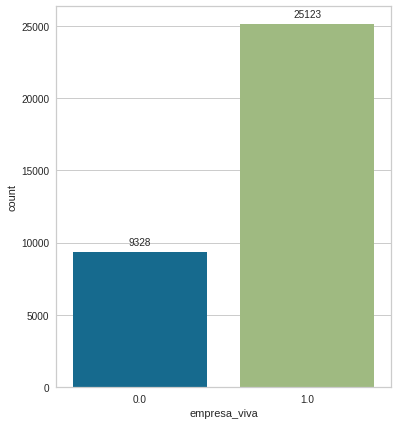

In [9]:
plt.figure(figsize=(6, 7))
splot = sns.countplot('empresa_viva', data=df_yX)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),
               (p.get_x() + p.get_width() / 2.,p.get_height()), ha = 'center', va = 'center', xytext = (0, 10),
               textcoords = 'offset points')

In [10]:
var_categoricas = ['LCIIU', 'desc_organizacion', 'import_export', 'ciudad', 'Sector', 'Tamaño_empresa']
var_not_categoricas = [i for i in df_yX.columns if i not in var_categoricas]

## Encoding & standarizing

In [11]:
encoder = OneHotEncoder()
X_cat_ohe = encoder.fit_transform(df_yX[var_categoricas])

categories_ohe = []
for i in range(len(encoder.categories_)):
    for j in range(len(encoder.categories_[i])):
        cats = encoder.categories_[i][j]
        categories_ohe.append(cats)

df_yX_cat = pd.DataFrame(X_cat_ohe.toarray(),
                         columns=categories_ohe)

# Df encoded but not standarize
df_yX_ohe = pd.concat([
                       df_yX[var_not_categoricas].reset_index(drop=True),
                       df_yX_cat
                      ], 
                      axis='columns')

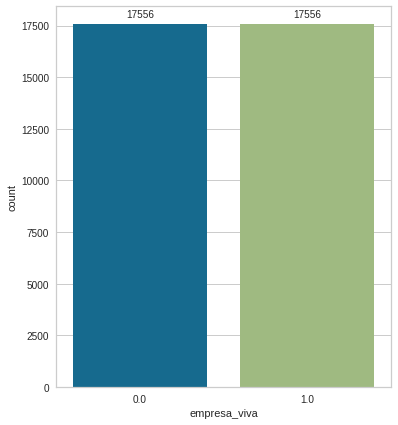

In [12]:
# Target variable and features
y = df_yX_ohe['empresa_viva']
X = df_yX_ohe.iloc[:,1:]

# Train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Balance labels in target variable
X_train, y_train = SMOTE(random_state = 123).fit_sample(X_train, y_train)
plt.figure(figsize=(6, 7))
splot = sns.countplot(y_train)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),
               (p.get_x() + p.get_width() / 2.,p.get_height()), ha = 'center', va = 'center', xytext = (0, 10),
               textcoords = 'offset points')
  
X_train = pd.DataFrame(data = X_train,   
                  columns =  X_test.columns.to_list())

# Modeling

## Logit

In [39]:
%%time

y = df_yX_ohe['empresa_viva']
X = df_yX_ohe.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train, y_train = SMOTE(random_state = 123).fit_sample(X_train, y_train)

lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)
y_pred = lg_model.predict(X_test)
lg_model.score(X_test, y_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2769
         1.0       0.73      1.00      0.84      7567

    accuracy                           0.73     10336
   macro avg       0.37      0.50      0.42     10336
weighted avg       0.54      0.73      0.62     10336

CPU times: user 1.07 s, sys: 47.6 ms, total: 1.12 s
Wall time: 1.01 s


AUC ROC
0.499471388925598
------------------------------------------------------


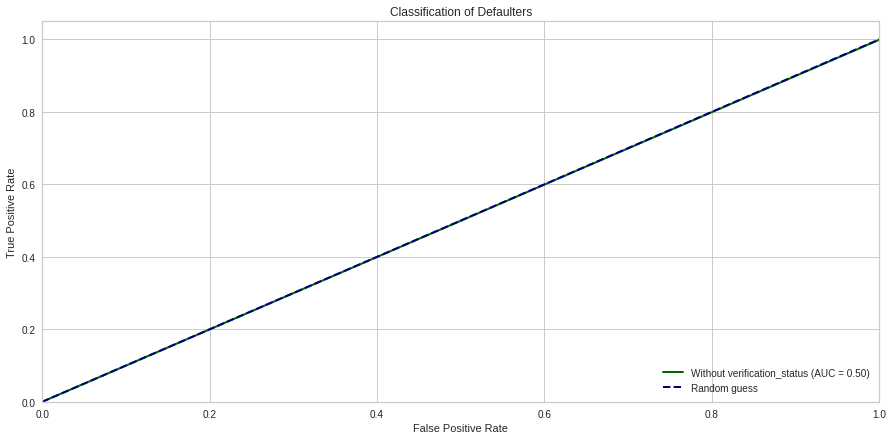

In [40]:
metric_roc_auc = roc_auc_score(y_test, y_pred)
plot_roc(pd.DataFrame(y_test).iloc[:,0].astype(int).tolist(), pd.DataFrame(y_pred).iloc[:,0].astype(int).tolist())

## Decision Tree

In [34]:
%%time

y = df_yX_ohe['empresa_viva']
X = df_yX_ohe.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train, y_train = SMOTE(random_state = 123).fit_sample(X_train, y_train)

DT_classifier = DecisionTreeClassifier(random_state=123, max_depth=8, criterion='gini')
DT_classifier = DT_classifier.fit(X_train, y_train)
y_pred = DT_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.41      0.32      0.36      2769
         1.0       0.77      0.83      0.80      7567

    accuracy                           0.69     10336
   macro avg       0.59      0.58      0.58     10336
weighted avg       0.67      0.69      0.68     10336

CPU times: user 1.03 s, sys: 7.92 ms, total: 1.04 s
Wall time: 1.04 s


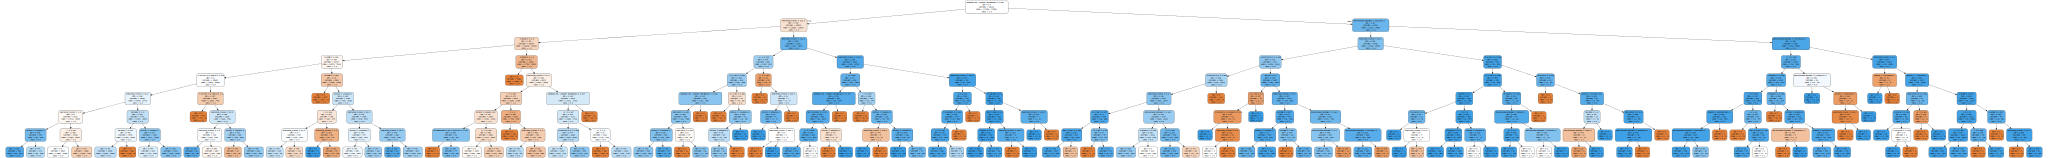

In [35]:
graphviz_data = export_graphviz(DT_classifier,
                                out_file=None,
                                feature_names=X.columns,
                                class_names=y.astype(str).unique(),
                                filled=True, rounded=True, special_characters=True)  

graph = graphviz.Source(graphviz_data)
SVG(graph.pipe(format='svg'))

AUC ROC
0.5761386077798893
------------------------------------------------------


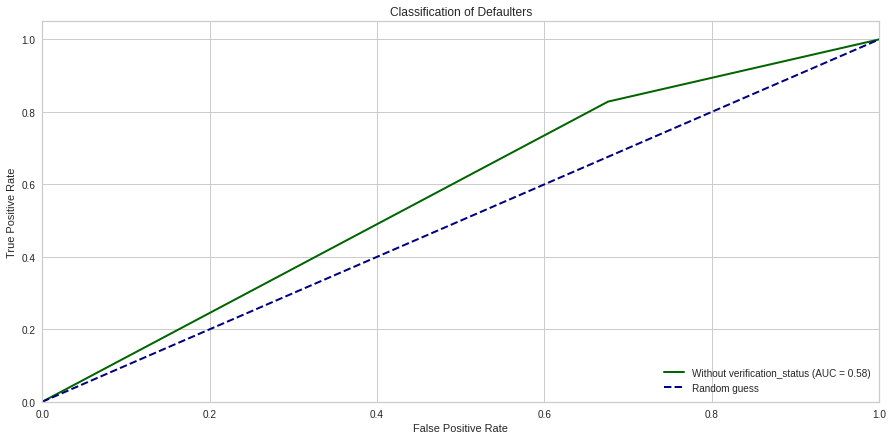

In [37]:
metric_roc_auc = roc_auc_score(y_test, y_pred)
plot_roc(pd.DataFrame(y_test).iloc[:,0].astype(int).tolist(), pd.DataFrame(y_pred).iloc[:,0].astype(int).tolist())

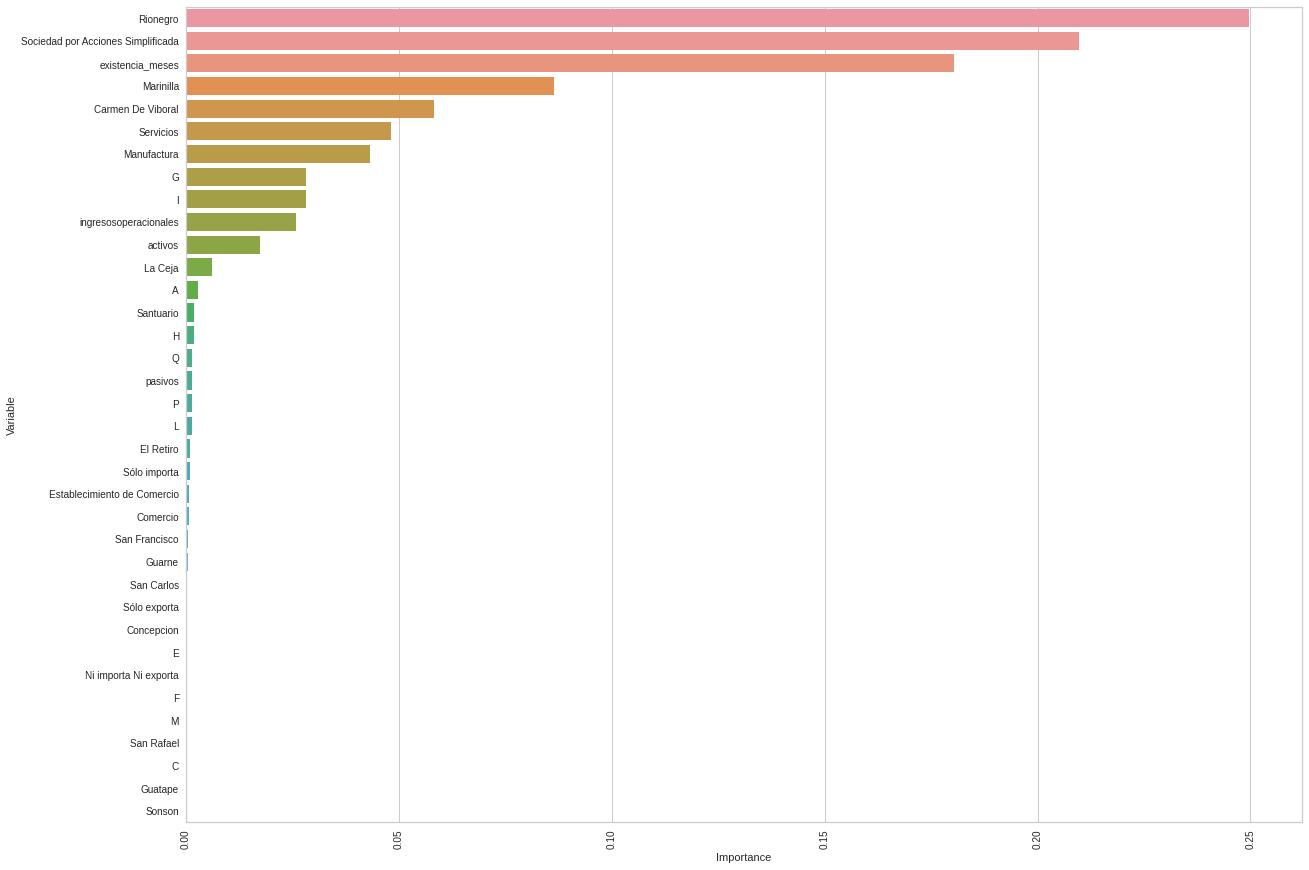

In [16]:
feature_importances = pd.DataFrame(DT_classifier.feature_importances_,
                                   index = X.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False).reset_index().rename(columns={'index':'Variable'})

plt.figure(figsize=(20,15))
sns.barplot(y = 'Variable',
            x = 'Importance',
            data = feature_importances[feature_importances['Importance'] != 0])
plt.xticks(rotation=90);

## Random Forest

In [30]:
%%time

y = df_yX_ohe['empresa_viva']
X = df_yX_ohe.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train, y_train = SMOTE(random_state = 123).fit_sample(X_train, y_train)

RF_classifier = RandomForestClassifier(n_estimators= 100, random_state=43,
                                       criterion='gini', max_depth = 9,oob_score = True, max_features = 'auto' ) 
RF_classifier.fit(X_train, y_train)
y_pred = RF_classifier.predict(X_test)

y_pred_prob = pd.DataFrame(RF_classifier.predict_proba(X_test))
y_pred_prob_Todos = pd.DataFrame(RF_classifier.predict_proba(X), columns = ['PROB_0','PROB_1'])

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.42      0.47      0.44      2769
         1.0       0.80      0.76      0.78      7567

    accuracy                           0.68     10336
   macro avg       0.61      0.61      0.61     10336
weighted avg       0.69      0.68      0.69     10336

CPU times: user 3.81 s, sys: 11.5 ms, total: 3.82 s
Wall time: 3.83 s


AUC ROC
0.6149492844063599
------------------------------------------------------


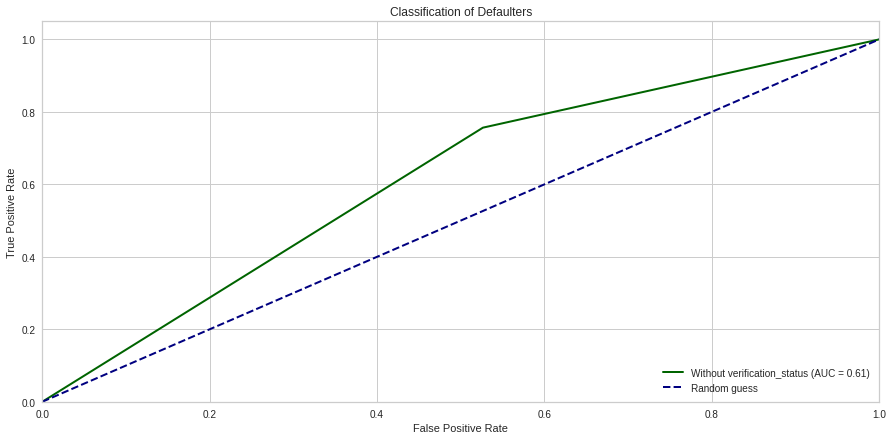

In [33]:
metric_roc_auc = roc_auc_score(y_test, y_pred)
plot_roc(pd.DataFrame(y_test).iloc[:,0].astype(int).tolist(), pd.DataFrame(y_pred).iloc[:,0].astype(int).tolist())

{'VARIANZA EXPLICADA EN LAS PRIMERAS 50 variables': 99.85719411398868}


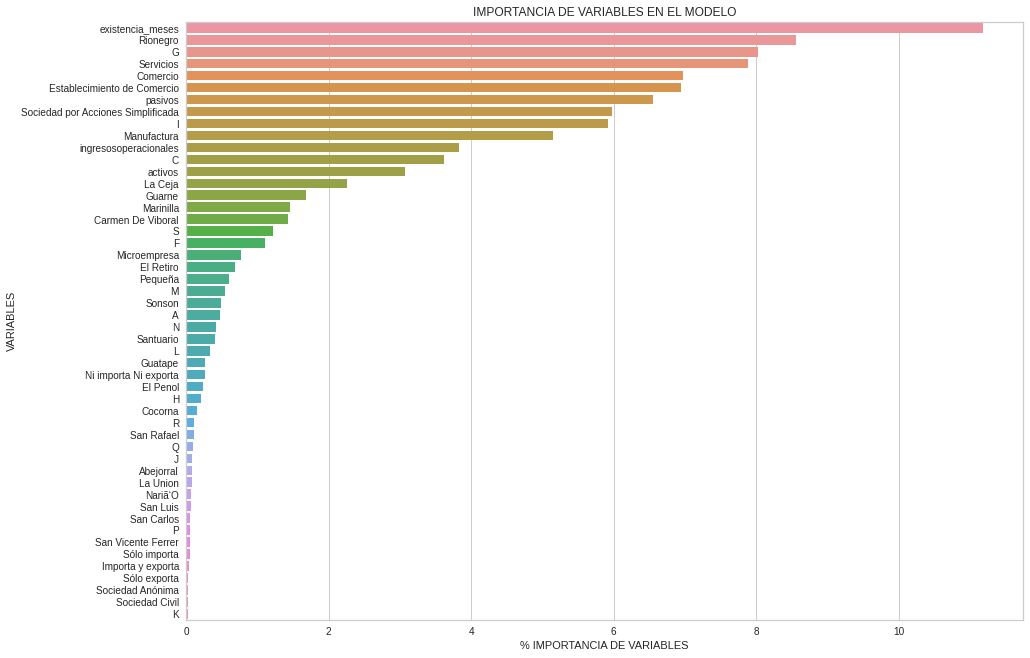

In [27]:
feature_importances = pd.DataFrame(RF_classifier.feature_importances_,
                                   index = X_test.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

vv = 50
p = feature_importances[:vv].apply(lambda x: x*100).reset_index()



print({'VARIANZA EXPLICADA EN LAS PRIMERAS {} variables'.format(vv):(p.iloc[:vv,1].sum())})
plt.figure(figsize = (15,11))
plt.title('IMPORTANCIA DE VARIABLES EN EL MODELO')
sns.barplot(data = p, y = 'index', x = 'importance')
plt.xlabel('% IMPORTANCIA DE VARIABLES')
plt.ylabel('VARIABLES')
plt.show()

## XGBoost

In [161]:
%%time

def hyperopt_train_test(params):
    clf = XGBClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()
space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'n_estimators': hp.choice('n_estimators', range(1,20)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1))
}
best = 0
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=500, trials=trials)
print('best:')
print(best)

100%|██████████| 500/500 [51:58<00:00,  6.24s/trial, best loss: -0.7821151221637777]  
best:
{'learning_rate': 0.5073084562465889, 'max_depth': 18, 'n_estimators': 17}
CPU times: user 1h 40min 40s, sys: 28.8 s, total: 1h 41min 8s
Wall time: 51min 58s


In [41]:
y = df_yX_ohe['empresa_viva']
X = df_yX_ohe.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train, y_train = SMOTE(random_state = 123).fit_sample(X_train, y_train)

XGB_classifier = xgb.XGBClassifier(learning_rate = best.get('learning_rate'), max_depth = best.get('max_depth'), n_estimators = best.get('n_estimators'))
XGB_classifier.fit(X_train,y_train)
XGB_pred = XGB_classifier.predict(X_test)

print(classification_report(y_test, XGB_pred))

NameError: name 'best' is not defined

In [ ]:
metric_roc_auc = roc_auc_score(y_test, XGB_pred)
plot_roc(pd.DataFrame(y_test).iloc[:,0].astype(int).tolist(), pd.DataFrame(XGB_pred).iloc[:,0].astype(int).tolist())

## SVM

### Standarize variables

In [ ]:
X_standard = StandardScaler().fit_transform(df_yX[['activos', 'pasivos', 'ingresosoperacionales']])
df_X_standard = pd.DataFrame(X_standard,
                             columns=['activos', 'pasivos', 'ingresosoperacionales'])

df_yX_ohe_standard = pd.concat([
                                df_yX[['empresa_viva', 'existencia_meses']].reset_index(drop=True),
                                df_X_standard,
                                df_yX_cat
                               ], 
                               axis='columns')

### Linear SVM

In [131]:
%%time

y = df_yX_ohe_standard['empresa_viva']
X = df_yX_ohe_standard.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train, y_train = SMOTE(random_state=123).fit_sample(X_train, y_train)

SVMk_classifier = LinearSVC(max_iter=5000)
SVMk_classifier.fit(X_train, y_train)
y_pred = SVMk_classifier.predict(X_test)

print(f'\n{classification_report(y_test, y_pred)}')

Error en entrenamiento:	0.3585
Error en prueba:	0.4340

              precision    recall  f1-score   support

         0.0       0.36      0.78      0.50      2847
         1.0       0.85      0.49      0.62      7489

    accuracy                           0.57     10336
   macro avg       0.61      0.63      0.56     10336
weighted avg       0.72      0.57      0.58     10336



### Gaussian SVM

In [133]:
%%time

y = df_yX_ohe_standard['empresa_viva']
X = df_yX_ohe_standard.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train, y_train = SMOTE(random_state=123).fit_sample(X_train, y_train)

SVMg_classifier = SVC(kernel='rbf', gamma = 0.001)
SVMg_classifier.fit(X_train, y_train)
y_pred = SVMg_classifier.predict(X_test)

print(f'\n{classification_report(y_test, y_pred)}')

Error en entrenamiento:	0.3585
Error en prueba:	0.4340

              precision    recall  f1-score   support

         0.0       0.36      0.86      0.51      2847
         1.0       0.89      0.41      0.56      7489

    accuracy                           0.54     10336
   macro avg       0.62      0.64      0.54     10336
weighted avg       0.74      0.54      0.55     10336



In [134]:
%%time

y = df_yX_ohe_standard['empresa_viva']
X = df_yX_ohe_standard.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train, y_train = SMOTE(random_state=123).fit_sample(X_train, y_train)

SVMg_classifier = SVC(kernel='rbf', gamma = 0.7)
SVMg_classifier.fit(X_train, y_train)
y_pred = SVMg_classifier.predict(X_test)

print(f'\n{classification_report(y_test, y_pred)}')

Error en entrenamiento:	0.3585
Error en prueba:	0.4340

              precision    recall  f1-score   support

         0.0       0.41      0.55      0.47      2847
         1.0       0.80      0.69      0.74      7489

    accuracy                           0.65     10336
   macro avg       0.60      0.62      0.61     10336
weighted avg       0.69      0.65      0.67     10336

CPU times: user 5min 39s, sys: 200 ms, total: 5min 39s
Wall time: 5min 40s


In [135]:
%%time

param_grid = {'C':     [2**i for i in range(-5, 7, 1)], 
              'gamma': [2**i for i in range(-5, 7, 1)]}

grid_clf = GridSearchCV(SVC(kernel='rbf'), 
                   param_grid=param_grid, 
                   verbose=1, 
                   return_train_score=True
                   )

y = df_yX_ohe_standard['empresa_viva']
X = df_yX_ohe_standard.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train, y_train = SMOTE(random_state=123).fit_sample(X_train, y_train)

grid_clf.fit(X_train, y_train)

display(pd.DataFrame(grid_clf.cv_results_))

print(grid_clf.best_params_)
print(grid_clf.best_score_)

{'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64],
 'gamma': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]}

# Example of predict new data

In [38]:
# Export model
joblib.dump(RF_classifier, './random_forest_model.joblib')

# Load Model
loaded = joblib.load('./random_forest_model.joblib')

# New data
new_data = pd.DataFrame(df_yX.iloc[206,1:]).T.reset_index(drop=True)

# Encoding categorical variables from new data
new_data_X = pd.concat([df_yX.iloc[:,1:], new_data])
new_data_encoder = encoder.fit_transform(pd.DataFrame(new_data_X[var_categoricas]))
new_data_encoded = pd.DataFrame(new_data_encoder.toarray(),
                                columns=categories_ohe)
new_data_encoded = new_data_encoded.iloc[-1,:].to_frame().T

new_data_ohe = pd.concat([
                       new_data[['existencia_meses', 'activos', 'pasivos', 'ingresosoperacionales']].reset_index(drop=True),
                       new_data_encoded.reset_index(drop=True)
                      ], 
                      axis='columns')

# Using Model for Predicting labels for new data
new_data_predict = pd.DataFrame(loaded.predict(new_data_ohe), columns=['empresa_viva'])
new_data_pred_prob = pd.DataFrame(loaded.predict_proba(new_data_ohe), columns=['PROB_0', 'PROB_1'])

# Create dataframe with new data and results
new_data_modeled = pd.concat([new_data, new_data_predict, new_data_pred_prob['PROB_1']], axis=1)
new_data_modeled

,LCIIU,desc_organizacion,import_export,ciudad,activos,pasivos,ingresosoperacionales,Sector,Tamaño_empresa,existencia_meses,empresa_viva,PROB_1
0,M,Sociedad por Acciones Simplificada,Ni importa Ni exporta,El Retiro,3126423121.0,3096959934.0,0.0,Servicios,Microempresa,144,1.0,0.752641
